# nuScenes prediction tutorial
<img src="https://www.nuscenes.org/public/tutorials/trajectory.gif" width="300" align="left">

This notebook serves as an introduction to the new functionality added to the nuScenes devkit for the prediction challenge.

It is organized into the following sections:

1. Data splits for the challenge
2. Getting past and future data for an agent 
3. Changes to the Map API
4. Overview of input representation
5. Model implementations
6. Making a submission to the challenge

In [105]:
from nuscenes import NuScenes

# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = '/media/data/nuscenes-data/'

nuscenes = NuScenes('v1.0-trainval', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 34.610 seconds.
Reverse indexing ...
Done reverse indexing in 5.6 seconds.


## 1. Data Splits for the Prediction Challenge

This section assumes basic familiarity with the nuScenes [schema](https://www.nuscenes.org/nuscenes#data-format).

The goal of the nuScenes prediction challenge is to predict the future location of agents in the nuScenes dataset. Agents are indexed by an instance token and a sample token. To get a list of agents in the train and val split of the challenge, we provide a function called `get_prediction_challenge_split`.

The get_prediction_challenge_split function returns a list of strings of the form {instance_token}_{sample_token}. In the next section, we show how to use an instance token and sample token to query data for the prediction challenge.

In [106]:
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
full_train = get_prediction_challenge_split("train", dataroot=DATAROOT)
print(full_train[:10])

['4d87aaf2d82549969f1550607ef46a63_faf2ea71b30941329a3c3f3866cec714', '4d87aaf2d82549969f1550607ef46a63_fa3f3d82b2b94da39f67bffc4e16d5db', '4d87aaf2d82549969f1550607ef46a63_903f32e4fd8247de8f20aa989e157b2a', '4d87aaf2d82549969f1550607ef46a63_ab44d8e463d54d0ebb18eb66bbc1e5eb', '4d87aaf2d82549969f1550607ef46a63_cc5951ca9cb240d5a7a0738fdec37634', '4d87aaf2d82549969f1550607ef46a63_5f671d1b44fa4938814706fc97889791', '4d87aaf2d82549969f1550607ef46a63_f8e421e9a9d74bc8a23c5ba60e297c51', '4d87aaf2d82549969f1550607ef46a63_2e8c628a9a8a4454914b725448afa278', '4d87aaf2d82549969f1550607ef46a63_70589de96aa44f48b3308558339042c3', 'f235a00b24c34bde85f787ef23058dac_f5c3f3c0a9414015a0430ea7716ac7a8']


## 2. Getting past and future data for an agent

We provide a class called `PredictHelper` that provides methods for querying past and future data for an agent. This class is instantiated by wrapping an instance of the `NuScenes` class. 

In [107]:
from nuscenes.prediction import PredictHelper
helper = PredictHelper(nuscenes)

To get the data for an agent at a particular point in time, use the `get_sample_annotation` method.

In [112]:
instance_token, sample_token = full_train[0].split("_")
annotation = helper.get_sample_annotation(instance_token, sample_token)
print(annotation)
print(helper.get_map_name_from_sample_token(sample_token))

{'token': '7f4d3fb912f44a5b8e8ddc989062b853', 'sample_token': 'faf2ea71b30941329a3c3f3866cec714', 'instance_token': '4d87aaf2d82549969f1550607ef46a63', 'visibility_token': '4', 'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'], 'translation': [739.332, 1528.803, 1.668], 'size': [3.402, 12.988, 3.111], 'rotation': [0.9357829112786893, 0.0, 0.0, -0.3525767192523928], 'prev': '47a2625a40f04fbab41b22fe8be7a161', 'next': '998e8672c7894776874434045a71c879', 'num_lidar_pts': 256, 'num_radar_pts': 23, 'category_name': 'vehicle.bus.rigid'}
boston-seaport


To get the future/past of an agent, use the `get_past_for_agent`/`get_future_for_agent` methods. If the `in_agent_frame` parameter is set to true, the coordinates will be in the agent's local coordinate frame. Otherwise, they will be in the global frame.

In [109]:
future_xy_local = helper.get_future_for_agent(instance_token, sample_token, seconds=3, in_agent_frame=True)
future_xy_local

array([[ 0.03461636,  2.43531101],
       [ 0.06848134,  4.86996215],
       [ 0.1030977 ,  7.30527315],
       [ 0.11408296,  8.81882141],
       [ 0.12497671, 10.33095842],
       [ 0.13662184, 11.84375529]])

The agent's coordinate frame is centered on the agent's current location and the agent's heading is aligned with the positive y axis. For example, the last coordinate in `future_xy_local` corresponds to a location 0.31 meters to the left and 9.67 meters in front of the agents starting location.

In [110]:
future_xy_global = helper.get_future_for_agent(instance_token, sample_token, seconds=3, in_agent_frame=False)
future_xy_global

array([[ 741.139, 1527.17 ],
       [ 742.946, 1525.538],
       [ 744.753, 1523.905],
       [ 745.883, 1522.898],
       [ 747.012, 1521.892],
       [ 748.141, 1520.885]])

Note that you can also return the entire annotation record by passing `just_xy=False`. However in this case, `in_agent_frame` is not taken into account.

In [82]:
helper.get_future_for_agent(instance_token, sample_token, seconds=3, in_agent_frame=True, just_xy=False)

[{'token': '998e8672c7894776874434045a71c879',
  'sample_token': 'fa3f3d82b2b94da39f67bffc4e16d5db',
  'instance_token': '4d87aaf2d82549969f1550607ef46a63',
  'visibility_token': '4',
  'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'],
  'translation': [741.139, 1527.17, 1.685],
  'size': [3.402, 12.988, 3.111],
  'rotation': [0.9350114818144081, 0.0, 0.0, -0.35461744017352664],
  'prev': '7f4d3fb912f44a5b8e8ddc989062b853',
  'next': '0e93a881058649aba3ca2c86a4052e2c',
  'num_lidar_pts': 242,
  'num_radar_pts': 25,
  'category_name': 'vehicle.bus.rigid'},
 {'token': '0e93a881058649aba3ca2c86a4052e2c',
  'sample_token': '903f32e4fd8247de8f20aa989e157b2a',
  'instance_token': '4d87aaf2d82549969f1550607ef46a63',
  'visibility_token': '4',
  'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'],
  'translation': [742.946, 1525.538, 1.702],
  'size': [3.402, 12.988, 3.111],
  'rotation': [0.9342356020271255, 0.0, 0.0, -0.3566564732414294],
  'prev': '998e8672c7894776874434045a71c

If you would like to return the data for the entire sample, as opposed to one agent in the sample, you can use the `get_annotations_for_sample` method. This will return a list of records for each annotated agent in the sample.

In [83]:
# sample   -> a certain timestep in a given scenario
# instance -> a given agent in the scenario, id constant over timesteps

sample = helper.get_annotations_for_sample(sample_token)

s = set()
for i in range(len(sample)):
    s.add(sample[i]['instance_token'])
print(len(s))


22


Note that there are `get_future_for_sample` and `get_past_for_sample` methods that are analogous to the `get_future_for_agent` and `get_past_for_agent` methods.

We also provide methods to compute the velocity, acceleration, and heading change rate of an agent at a given point in time

In [84]:
# We get new instance and sample tokens because these methods require computing the difference between records.
instance_token_2, sample_token_2 = full_train[5].split("_")

# Meters / second.
print(f"Velocity: {helper.get_velocity_for_agent(instance_token_2, sample_token_2)}\n")

# Meters / second^2.
print(f"Acceleration: {helper.get_acceleration_for_agent(instance_token_2, sample_token_2)}\n")

# Radians / second.
print(f"Heading Change Rate: {helper.get_heading_change_rate_for_agent(instance_token_2, sample_token_2)}")

Velocity: 3.7882726677122176

Acceleration: 1.8984690951395735

Heading Change Rate: 0.00874472551395323


## Changes to the Map API

We've added a couple of methods to the Map API to help query lane center line information.

In [85]:
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(map_name='singapore-onenorth', dataroot=DATAROOT)

To get the closest lane to a location, use the `get_closest_lane` method. To see the internal data representation of the lane, use the `get_lane_record` method. 
You can also explore the connectivity of the lanes, with the `get_outgoing_lanes` and `get_incoming_lane` methods.

In [86]:
x, y, yaw = 395, 1095, 0
closest_lane = nusc_map.get_closest_lane(x, y, radius=2)
closest_lane

'5933500a-f0f2-4d69-9bbc-83b875e4a73e'

In [87]:
lane_record = nusc_map.get_arcline_path(closest_lane)
lane_record

[{'start_pose': [421.2419602954602, 1087.9127960414617, 2.739593514975998],
  'end_pose': [391.7142849867393, 1100.464077182952, 2.7365754617298705],
  'shape': 'LSR',
  'radius': 999.999,
  'segment_length': [0.23651121617864976,
   28.593481378991886,
   3.254561444252876]}]

In [88]:
nusc_map.get_incoming_lane_ids(closest_lane)

['f24a067b-d650-47d0-8664-039d648d7c0d']

In [89]:
nusc_map.get_outgoing_lane_ids(closest_lane)

['0282d0e3-b6bf-4bcd-be24-35c9ce4c6591',
 '28d15254-0ef9-48c3-9e06-dc5a25b31127']

To help manipulate the lanes, we've added an `arcline_path_utils` module. For example, something you might want to do is discretize a lane into a sequence of poses.

In [90]:
from nuscenes.map_expansion import arcline_path_utils
poses = arcline_path_utils.discretize_lane(lane_record, resolution_meters=1)
poses

[(421.2419602954602, 1087.9127960414617, 2.739593514975998),
 (420.34712994585345, 1088.2930152148274, 2.739830026428688),
 (419.45228865726136, 1088.6732086473173, 2.739830026428688),
 (418.5574473686693, 1089.0534020798073, 2.739830026428688),
 (417.66260608007724, 1089.433595512297, 2.739830026428688),
 (416.76776479148515, 1089.813788944787, 2.739830026428688),
 (415.87292350289306, 1090.1939823772768, 2.739830026428688),
 (414.97808221430097, 1090.5741758097668, 2.739830026428688),
 (414.0832409257089, 1090.9543692422567, 2.739830026428688),
 (413.1883996371168, 1091.3345626747464, 2.739830026428688),
 (412.29355834852475, 1091.7147561072363, 2.739830026428688),
 (411.39871705993266, 1092.0949495397263, 2.739830026428688),
 (410.5038757713406, 1092.4751429722162, 2.739830026428688),
 (409.6090344827485, 1092.8553364047061, 2.739830026428688),
 (408.7141931941564, 1093.2355298371958, 2.739830026428688),
 (407.81935190556436, 1093.6157232696858, 2.739830026428688),
 (406.92451061697

Given a query pose, you can also find the closest pose on a lane.

In [91]:
closest_pose_on_lane, distance_along_lane = arcline_path_utils.project_pose_to_lane((x, y, yaw), lane_record)

In [92]:
print(x, y, yaw)
closest_pose_on_lane

395 1095 0


(396.25524909914367, 1098.5289922434013, 2.739830026428688)

In [93]:
# Meters.
distance_along_lane

27.5

To find the entire length of the lane, you can use the `length_of_lane` function.

In [94]:
arcline_path_utils.length_of_lane(lane_record)

32.08455403942341

You can also compute the curvature of a lane at a given distance along the lane.

In [95]:
# 0 means it is a straight lane.
arcline_path_utils.get_curvature_at_distance_along_lane(distance_along_lane, lane_record)

0

## 4. Input Representation

It is common in the prediction literature to represent the state of an agent as a tensor containing information about the semantic map (such as the drivable area and walkways), as well the past locations of surrounding agents.

Each paper in the field chooses to represent the input in a slightly different way. For example, [CoverNet](https://arxiv.org/pdf/1911.10298.pdf) and [MTP](https://arxiv.org/pdf/1808.05819.pdf) choose to rasterize the map information and agent locations into a three channel RGB image. But [Rules of the Road](http://openaccess.thecvf.com/content_CVPR_2019/papers/Hong_Rules_of_the_Road_Predicting_Driving_Behavior_With_a_Convolutional_CVPR_2019_paper.pdf) decides to use a "taller" tensor with information represented in different channels.

We provide a module called `input_representation` that is meant to make it easy for you to define your own input representation. In short, you need to define your own `StaticLayerRepresentation`, `AgentRepresentation`, and `Combinator`.

The `StaticLayerRepresentation` controls how the static map information is represented. The `AgentRepresentation` controls how the locations of the agents in the scene are represented. The `Combinator` controls how these two sources of information are combined into a single tensor.

For more information, consult `input_representation/interface.py`.

To help get you started, we've provided implementations of input representation used in CoverNet and MTP.

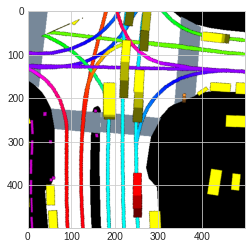

In [104]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

# From ...
# renderable layers: 'drivable_area', 'road_segment', 'road_block', 'lane', 'ped_crossing', 'walkway', 'stop_line', 'carpark_area']

static_layer_rasterizer = StaticLayerRasterizer(helper, layer_names=['drivable_area', 'ped_crossing', 'traffic_light'])
agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

# instance_token_img, sample_token_img = 'bc38961ca0ac4b14ab90e547ba79fbb6','356d81f38dd9473ba590f39e266f54e5'
# instance_token_img, sample_token_img = 'bc38961ca0ac4b14ab90e547ba79fbb6', '7626dde27d604ac28a0240bdd54eba7a'
instance_token_img, sample_token_img = full_train[80].split('_')
anns = [ann for ann in nuscenes.sample_annotation if ann['instance_token'] == instance_token_img]
img = mtp_input_representation.make_input_representation(instance_token_img, sample_token_img)

plt.imshow(img)

## Model Implementations

We've provided PyTorch implementations for CoverNet and MTP. Below we show, how to make predictions on the previously created input representation.

In [53]:
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
from nuscenes.prediction.models.covernet import CoverNet
import torch

Both models take a CNN backbone as a parameter. We've provided wrappers for ResNet and MobileNet v2. In this example, we'll use ResNet50.

In [54]:
backbone = ResNetBackbone('resnet50')
mtp = MTP(backbone, num_modes=2)

# Note that the value of num_modes depends on the size of the lattice used for CoverNet.
covernet = CoverNet(backbone, num_modes=64)

The second input is a tensor containing the velocity, acceleration, and heading change rate for the agent.

In [55]:
agent_state_vector = torch.Tensor([[helper.get_velocity_for_agent(instance_token_img, sample_token_img),
                                    helper.get_acceleration_for_agent(instance_token_img, sample_token_img),
                                    helper.get_heading_change_rate_for_agent(instance_token_img, sample_token_img)]])

In [56]:
image_tensor = torch.Tensor(img).permute(2, 0, 1).unsqueeze(0)

In [57]:
# Output has 50 entries.
# The first 24 are x,y coordinates (in the agent frame) over the next 6 seconds at 2 Hz for the first mode.
# The second 24 are the x,y coordinates for the second mode.
# The last 2 are the logits of the mode probabilities
mtp(image_tensor, agent_state_vector)

tensor([[-9.2193e-01, -7.3153e-01,  2.3657e-01, -3.8394e-01, -1.4829e-01,
         -1.0429e-01,  5.2936e-02, -2.9130e-01, -6.9365e-01, -4.5404e-01,
          4.6453e-02,  9.4260e-02, -1.5560e-01, -1.7607e-02, -1.3632e-01,
          1.5654e-01,  5.6831e-01,  3.2620e-01,  1.0976e-01, -1.6606e-01,
         -7.2221e-02,  4.6982e-02,  4.4489e-01,  2.1350e-01, -1.9479e-01,
          1.0352e-01, -1.8074e-02,  4.5716e-01, -9.1210e-02,  1.2169e-01,
          3.0043e-01, -1.6761e-02,  1.9396e-01, -1.9395e-01,  3.9229e-01,
          3.0832e-01, -2.5648e-01, -4.5704e-01,  1.3305e-01,  2.2953e-01,
         -2.8046e-04, -1.5869e-01,  3.7077e-01,  8.8285e-02, -1.6533e-02,
          2.7354e-01, -2.2909e-01, -8.8961e-02, -1.2930e-01,  3.9122e-01]],
       grad_fn=<CatBackward>)

In [58]:
# CoverNet outputs a probability distribution over the trajectory set.
# These are the logits of the probabilities
logits = covernet(image_tensor, agent_state_vector)
print(logits)

tensor([[ 0.4888,  0.2937, -0.0403,  0.1221, -0.0287, -0.4960,  0.5409, -0.0567,
         -0.4861,  0.6176,  0.1690, -0.0881,  0.0389, -0.3527, -0.4616, -0.3541,
         -0.2958,  0.2184,  0.5603,  0.0822, -0.5686, -0.1666, -0.1436,  0.7056,
          0.7169, -0.3524, -0.2503, -0.0518,  0.2757,  0.1830,  0.1495, -0.1910,
          0.1038, -0.5135, -0.4020, -0.2102,  0.2464,  0.4432,  0.0457, -0.3904,
          0.2652,  0.1294, -0.4302, -0.2070, -0.1842, -0.4985, -0.1889, -0.1984,
         -0.1611,  0.4127, -0.1594, -0.3117, -0.2614,  0.4911,  0.0215, -0.1876,
          0.0051, -0.2127,  0.4380,  0.1055,  0.5743, -0.0915,  0.0668,  0.2451]],
       grad_fn=<AddmmBackward>)


The CoverNet model outputs a probability distribution over a set of trajectories. To be able to interpret the predictions, and perform inference with CoverNet, you need to download the trajectory sets from the nuscenes website. Download them from this [link](https://www.nuscenes.org/public/nuscenes-prediction-challenge-trajectory-sets.zip) and unzip them in a directory of your choice.

Uncomment the following code when you do so:

In [ ]:
#import pickle

# Epsilon is the amount of coverage in the set, 
# i.e. a real world trajectory is at most 8 meters from a trajectory in this set
# We released the set for epsilon = 2, 4, 8. Consult the paper for more information
# on how this set was created

#PATH_TO_EPSILON_8_SET = ""
#trajectories = pickle.load(open(PATH_TO_EPSILON_8_SET, 'rb'))

# Saved them as a list of lists
#trajectories = torch.Tensor(trajectories)

# Print 5 most likely predictions
#trajectories[logits.argsort(descending=True)[:5]]

We also provide two physics-based models - A constant velocity and heading model and a physics oracle. The physics oracle estimates the future trajectory of the agent with several physics based models and chooses the one that is closest to the ground truth. It represents the best performance a purely physics based model could achieve on the dataset.

In [59]:
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle

cv_model = ConstantVelocityHeading(sec_from_now=6, helper=helper)
physics_oracle = PhysicsOracle(sec_from_now=6, helper=helper)

The physics models can be called as functions. They take as input a string of the instance and sample token of the agent concatenated with an underscore ("_").

The output is a `Prediction` data type. The `Prediction` data type stores the predicted trajectories and their associated probabilities for the agent. We'll go over the `Prediction` type in greater detail in the next section.

In [60]:
cv_model(f"{instance_token_img}_{sample_token_img}")

Prediction(instance=bc38961ca0ac4b14ab90e547ba79fbb6, sample=356d81f38dd9473ba590f39e266f54e5, prediction=[[[ 392.74578    1148.00571422]
  [ 392.65555999 1147.80342843]
  [ 392.56533999 1147.60114265]
  [ 392.47511998 1147.39885686]
  [ 392.38489998 1147.19657108]
  [ 392.29467998 1146.99428529]
  [ 392.20445997 1146.79199951]
  [ 392.11423997 1146.58971372]
  [ 392.02401996 1146.38742794]
  [ 391.93379996 1146.18514215]
  [ 391.84357995 1145.98285637]
  [ 391.75335995 1145.78057058]]], probabilities=[1])

In [61]:
physics_oracle(f"{instance_token_img}_{sample_token_img}")

Prediction(instance=bc38961ca0ac4b14ab90e547ba79fbb6, sample=356d81f38dd9473ba590f39e266f54e5, prediction=[[[ 392.74578    1148.00571422]
  [ 392.65555999 1147.80342843]
  [ 392.56533999 1147.60114265]
  [ 392.47511998 1147.39885686]
  [ 392.38489998 1147.19657108]
  [ 392.29467998 1146.99428529]
  [ 392.20445997 1146.79199951]
  [ 392.11423997 1146.58971372]
  [ 392.02401996 1146.38742794]
  [ 391.93379996 1146.18514215]
  [ 391.84357995 1145.98285637]
  [ 391.75335995 1145.78057058]]], probabilities=[1])

## 6. Making a submission to the challenge

Participants must submit a zipped json file containing serialized `Predictions` for each agent in the validation set.

The previous section introduced the `Prediction` data type. In this section, we explain the format in greater detail. 

A `Prediction` consists of four fields:

1. instance: The instance token for the agent.
2. sample: The sample token for the agent.
3. prediction: Prediction from model. A prediction can consist of up to 25 proposed trajectories. This field must be a numpy array with three dimensions (number of trajectories (also called modes), number of timesteps, 2).
4. probabilities: The probability corresponding to each predicted mode. This is a numpy array with shape `(number_of_modes,)`.

You will get an error if any of these conditions are violated.

In [ ]:
from nuscenes.eval.prediction.data_classes import Prediction
import numpy as np

In [ ]:
# This would raise an error because instance is not a string.

#Prediction(instance=1, sample=sample_token_img,
#           prediction=np.ones((1, 12, 2)), probabilities=np.array([1]))

In [ ]:
# This would raise an error because sample is not a string.

#Prediction(instance=instance_token_img, sample=2,
#           prediction=np.ones((1, 12, 2)), probabilities=np.array([1]))

In [ ]:
# This would raise an error because prediction is not a numpy array.

#Prediction(instance=instance_token_img, sample=sample_token_img,
#           prediction=np.ones((1, 12, 2)).tolist(), probabilities=np.array([1]))

In [ ]:
# This would throw an error because probabilities is not a numpy array. Uncomment to see.

#Prediction(instance=instance_token_img, sample=sample_token_img,
#           prediction=np.ones((1, 12, 2)), probabilities=[0.3])

In [ ]:
# This would throw an error because there are more than 25 predicted modes. Uncomment to see.

#Prediction(instance=instance_token_img, sample=sample_token_img,
#           prediction=np.ones((30, 12, 2)), probabilities=np.array([1/30]*30))

In [ ]:
# This would throw an error because the number of predictions and probabilities don't match. Uncomment to see.

#Prediction(instance=instance_token_img, sample=sample_token_img,
           #prediction=np.ones((13, 12, 2)), probabilities=np.array([1/12]*12))

To make a submission to the challenge, store your model predictions in a python list and save it to json. Then, upload a zipped version of your file to the eval server. 

For an example, see `eval/prediction/baseline_model_inference.py`